In this notebook, I will use simulated EEG signals, to show EpiNT's ability.

In [72]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import argparse
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from safetensors.torch import load_file
from EpiNT.models.EpiNT import EpiNT

In [73]:
config = {
    'patch_mask': False,
    'd_model': 512,
    'dim_feedforward': 2048,
    'num_heads': 8,
    'num_layers': 6,
    'patch_len': 256, 
    'stride_len': 256, 
    'sequence_len': 3072, 
    'dropout': 0.1, 
    'cls_token': True,
    'task': 'classification',
    'codebook_size': 512,
    'mask_ratio': 0,
    'head_dropout': 0.1,
    'seizure_task': 'hfo_ied_detec1'
}
args = argparse.Namespace(**config)
to_be_load_keys = ['embed', 'transformer_encoder', 'norm']

In [74]:
# --- Function to generate a frequency-modulated sine wave ---
def generate_freq_modulated_signal(freq_min, freq_max, fs=1024, duration=3.0, n_control_points=20):
    """
    Generates a sine wave whose instantaneous frequency is modulated over time.
    
    Args:
        freq_min (float): Minimum frequency in Hz.
        freq_max (float): Maximum frequency in Hz.
        fs (int): Sampling frequency in Hz.
        duration (float): Signal duration in seconds.
        n_control_points (int): Number of control points for modulation.
        
    Returns:
        signal (np.ndarray): The generated sine wave signal.
    """
    n = int(fs * duration)
    t = np.linspace(0, duration, n, endpoint=False)
    # Create a coarse grid of time points
    t_control = np.linspace(0, duration, n_control_points)
    # Randomly choose instantaneous frequency values at control points
    freq_control = np.random.uniform(low=freq_min, high=freq_max, size=n_control_points)
    # Interpolate to get instantaneous frequency at each time step
    inst_freq = np.interp(t, t_control, freq_control)
    # Integrate the instantaneous frequency to get phase
    phase = 2 * np.pi * np.cumsum(inst_freq) / fs
    signal = np.sin(phase)
    return signal

In [75]:
model_weights = '../weights/model.safetensors'
safetensor = load_file(model_weights)


model = EpiNT(args)
filtered_state_dict = {k: v for k, v in safetensor.items() if k.split('.')[0] in to_be_load_keys} 
print(filtered_state_dict.keys())
model.load_state_dict(filtered_state_dict, strict=False)
for name, param in model.named_parameters():
    param.requires_grad = False

dict_keys(['embed.cls_embed', 'embed.mask_encoding', 'embed.proj.bias', 'embed.proj.weight', 'norm.bias', 'norm.weight', 'transformer_encoder.0.attention.w_concat.bias', 'transformer_encoder.0.attention.w_concat.weight', 'transformer_encoder.0.attention.w_k.bias', 'transformer_encoder.0.attention.w_k.weight', 'transformer_encoder.0.attention.w_q.bias', 'transformer_encoder.0.attention.w_q.weight', 'transformer_encoder.0.attention.w_v.bias', 'transformer_encoder.0.attention.w_v.weight', 'transformer_encoder.0.ffn.linear1.bias', 'transformer_encoder.0.ffn.linear1.weight', 'transformer_encoder.0.ffn.linear2.bias', 'transformer_encoder.0.ffn.linear2.weight', 'transformer_encoder.0.norm1.bias', 'transformer_encoder.0.norm1.weight', 'transformer_encoder.0.norm2.bias', 'transformer_encoder.0.norm2.weight', 'transformer_encoder.1.attention.w_concat.bias', 'transformer_encoder.1.attention.w_concat.weight', 'transformer_encoder.1.attention.w_k.bias', 'transformer_encoder.1.attention.w_k.weight',

In [76]:
# generate simulated signals

# --- Parameters ---
fs = 1024             # Sampling frequency in Hz
duration = 3.0        # Signal duration in seconds
n_samples = int(fs * duration)  # Total time points per signal
n_signals_per_class = 50        # Number of examples per frequency

# --- Define frequency classes ---
frequency_classes = {
    # For Delta, use a very narrow range to simulate nearly constant 1 Hz.
    'Delta': (0.9, 1.1),
    # For Alpha, vary frequency between 8 and 12 Hz.
    'Alpha': (8, 12),
    # For Beta, vary frequency between 1 and 5 Hz (as specified).
    'Beta': (1, 5),
    # For Gamma, vary frequency between 40 and 80 Hz.
    'Gamma': (40, 80),
}

# --- Generate synthetic signals ---
signals = []
labels = []

for label, (f_min, f_max) in frequency_classes.items():
    for _ in range(n_signals_per_class):
        sig = generate_freq_modulated_signal(f_min, f_max, fs, duration)
        signals.append(sig)
        labels.append(label)

signals = np.array(signals)  # Shape: (n_signals, n_samples)
labels = np.array(labels)

print(f"Generated {len(signals)} signals with shape {signals.shape} and labels: {np.unique(labels)}")

Generated 200 signals with shape (200, 3072) and labels: ['Alpha' 'Beta' 'Delta' 'Gamma']


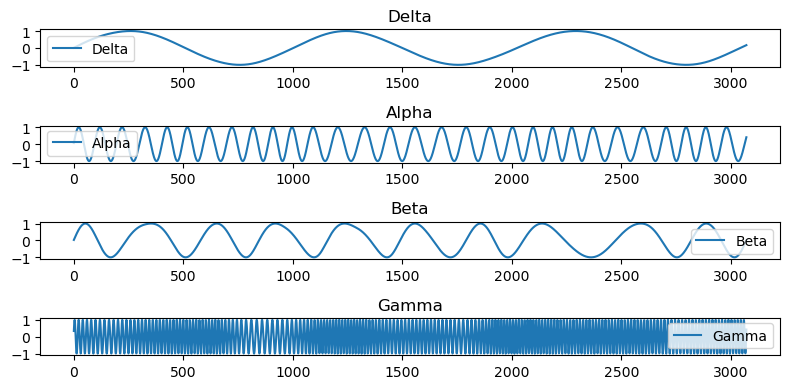

In [77]:
# visualize the signals
fig, ax = plt.subplots(len(frequency_classes), 1, figsize=(8, 4))
for i, (label, freq) in enumerate(frequency_classes.items()):
    ax[i].plot(signals[i * n_signals_per_class], label=label)
    ax[i].set_title(label)
    ax[i].legend()
plt.tight_layout()
plt.show()

In [78]:
# --- get features ---
signals_tensor = torch.tensor(signals, dtype=torch.float32)
pred, features = model(signals_tensor)
print(f"Extracted features shape: {features.shape}, predictions shape: {pred.shape}")

features = features.view(features.shape[0], -1)


Extracted features shape: torch.Size([200, 1, 512]), predictions shape: torch.Size([200, 2])


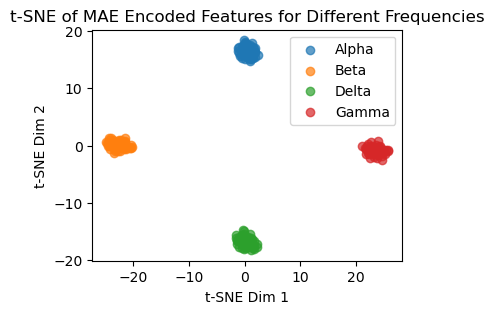

In [79]:
# use tsne to visualize the features
tsne = TSNE(n_components=2, random_state=42)
tsne_embeds = tsne.fit_transform(features)

# --- Visualization ---
plt.figure(figsize=(4, 3))
for freq_label in np.unique(labels):
    idx = labels == freq_label
    plt.scatter(tsne_embeds[idx, 0], tsne_embeds[idx, 1], label=freq_label, alpha=0.7)
plt.legend()
plt.title('t-SNE of MAE Encoded Features for Different Frequencies')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.show()